![Qiskit](https://github.com/Qiskit/qiskit-tutorials/raw/115c78962dda85bac29d679063b7d0d0ab1d1ab4/images/qiskit-heading.gif)

# Qiskit Bootcamp Parts III & IV: Aqua, Optimization, Machine Learning, and Chemistry

donny@ibm.com <br>_25-Oct-19_

# Gameplan

* Overview and basics
  * What is Aqua?
  * Structural Elements
  * Control flow
  * Interfaces
* Detailed component overview
* Tips and Tricks
* Learning more

But first, install Qiskit:

In [2]:
#!pip install qiskit

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Part III: Constructing and Executing Quantum Algorithms with Aqua

# What is Aqua?

Aqua is:
* An easy to use library for running many different quantum algorithms
* A collection of reusable components which can be mixed and matched in different algorithms

Aqua is very practically driven
* We have real chemists and clients who are trying to get things done
* It is exactly what you’d expect to spring out of rapid practical need… it is very function-driven and evolves rapidly
* The guts are not so inviting in some places because it is engineered and optimized to the nines
* If you need to do something, there is a good chance someone already put it in Aqua or should
  * **Please submit feature requests!**

# Plug and play components, not a circuit library

Keep in mind:

Aqua organizes reusable components into buckets, elements of which can be substituted for one another:
* Algorithms
* Variational forms
* Optimizers
* Other smaller buckets (translators, QFTs, oracles, feature maps)

It is not so much an “I give you parameters, you give me back a circuit” library, because in nearly all cases, running an algorithm is much more than executing a single circuit (e.g. VQE, QkernelSVM, etc.)

It’s not even so much about “give me x component,” it’s more “execute this algorithm, with this set of components,” allowing you to mix and match or add your own components

There are many tests, which give good examples of execution modes and components, as well as tutorials in the qiskit-tutorials repo

Get an IDE (Pycharm is good!) and step through the code!


# Structural Elements

It is easy to see Aqua as being composed of roughly four high-level elements:
* Algorithms - the control flow and logic in generally well contained inside the algorithm class file. 
* Interfaces - Aqua is meant to be highly accessible, so it has a lot of infrascructure to allow the graphical or JSON interfaces to be almost equally accessible as coding against the library directly (no small feat!)
   * JSON definitions and declarative interfaces are dispersed throughout
   * The UI and CLI are in the top level Aqua directory
* Components - These are objects which are shared by several algorithms, as mentioned above.
* Utilities - Aqua has many useful modules and helper classes that an algorithm and application developer might want. Examples include the operator classes, random matrix generator, mct, run_circutis.py, and much more.

# Applications Domains

Aqua also includes separate folders for domain specific applications and logic (work in progress). 
* Chemistry
* Optimization
* Finance
* AI

Previously, this logic was mostly integrated throughout Aqua, other than Chemistry. This is a new change, and the stacks within each area are still being organized.

# The Maxcut problem

Today, we're going to focus on a combinatorial optimization problem called **Maxcut**, which is solved by dividing the nodes of a weighted graph into two groups such that the egdes between the two groups carry the most possible weight. There's an [excellent notebook](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aqua/optimization/max_cut_and_tsp.ipynb) 📒 by Mezzacapo et al that goes into the problem in more detail, which I highly recommend. For our purposes, reviewing solution paths is a more important use of our time, and we will not be spending much time on the translation between the graph problem and the qubit operator.

Our solution path starts like this - we represent each node on the graph by a qubit, and the 0 or 1 state of the qubit represents which of the two groups each node occupies in a possible solution. Binary strings are possible solutions, describing how to divide the nodes into |0> group and |1> group. We can take the weights of the graph and turn them into a cost matrix on the vector space of these strings, such that this cost matrix represents an Ising hamiltonian whose minimum eignestate is our optimal solution.

Let's begin with a weight matrix w, representing the weights between edges of the graph. To make it easier to follow along with the above mentioned notebook, we'll use the same cost matrix.

In [67]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, SLSQP, COBYLA
from qiskit.aqua.components.variational_forms import RY, RYRZ
from qiskit.aqua import QuantumInstance
seed = 50

In [ ]:
# setup aqua logging
import logging
from qiskit.aqua._logging import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.INFO)

# Our graph:

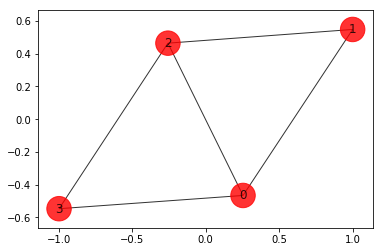

In [40]:
n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [41]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [42]:
qubitOp, offset = max_cut.get_max_cut_qubitops(w)

In [43]:
print(qubitOp.paulis)

[[(0.5+0j), Pauli(z=[True, True, False, False], x=[False, False, False, False])], [(0.5+0j), Pauli(z=[True, False, True, False], x=[False, False, False, False])], [(0.5+0j), Pauli(z=[False, True, True, False], x=[False, False, False, False])], [(0.5+0j), Pauli(z=[True, False, False, True], x=[False, False, False, False])], [(0.5+0j), Pauli(z=[False, False, True, True], x=[False, False, False, False])]]


In [44]:
from qiskit.aqua.operators.op_converter import to_matrix_operator
mat_op = to_matrix_operator(qubitOp)
print(mat_op.matrix)
# Note, these are the diagonal elements

[ 2.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j -1.5+0.j -0.5+0.j  0.5+0.j
  0.5+0.j -0.5+0.j -1.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j  2.5+0.j]


# First, Let's try Solving Exactly Using Exact Diagonalization

energy: -1.5
max-cut objective: -4.0
solution: [0. 1. 0. 1.]
solution objective: 4.0


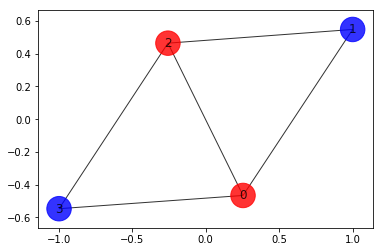

In [47]:
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

# Now, let's run VQE

## 🚨NOTE: YOU SHOULD SET `seed_transpiler` BECAUSE THE TRANSPILER IS STOCHASTIC

2019-10-25 04:49:19,370:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x11bbc7c18>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x11bbc7be0>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x11bbc7240>>
-- initial_point: Random seed
-- callback: None
-- operator: Representation: paulis, qubits: 4, size: 5
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: RY
-- num_parameters: 24
-- num_qubits: 4
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592

2019-10-25 04:49:21,994:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 32 returned 0.7922132217750304
2019-10-25 04:49:22,074:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 33 returned 0.5415898703183495
2019-10-25 04:49:22,148:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 34 returned 0.7854836789376654
2019-10-25 04:49:22,222:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 35 returned 0.5157863628805479
2019-10-25 04:49:22,295:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 36 returned 0.7368155399342534
2019-10-25 04:49:22,528:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 37 returned 0.6220339153951889
2019-10-25 04:49:22,605:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 38 returned 0.6898328857273588
2019-10-25 04:49:22,681:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 39 returned 0.4521986106681771
2019-10-25 04:49:22,754:qiskit.aqua.algorithms.a

2019-10-25 04:49:27,824:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 101 returned -1.3480666258615197
2019-10-25 04:49:27,911:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 102 returned -1.2543607126050536
2019-10-25 04:49:27,992:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 103 returned -1.3262720196092381
2019-10-25 04:49:28,078:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 104 returned -1.322693344354066
2019-10-25 04:49:28,161:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 105 returned -1.305357099589374
2019-10-25 04:49:28,250:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 106 returned -1.3328447319571082
2019-10-25 04:49:28,333:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 107 returned -1.363269009949721
2019-10-25 04:49:28,414:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 108 returned -1.2759549556046585
2019-10-25 04:49:28,493:qiskit.aqua

2019-10-25 04:49:33,580:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 169 returned -1.387392031124335
2019-10-25 04:49:33,653:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 170 returned -1.4236313406005274
2019-10-25 04:49:33,729:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 171 returned -1.4654150475507697
2019-10-25 04:49:33,803:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 172 returned -1.4298404915227538
2019-10-25 04:49:33,888:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 173 returned -1.430517577176551
2019-10-25 04:49:33,978:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 174 returned -1.4531359570542866
2019-10-25 04:49:34,060:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 175 returned -1.4267411714650844
2019-10-25 04:49:34,137:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 176 returned -1.4457053582698263
2019-10-25 04:49:34,212:qiskit.aqu

2019-10-25 04:49:39,150:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 237 returned -1.4723505509633754
2019-10-25 04:49:39,223:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 238 returned -1.474141881074867
2019-10-25 04:49:39,295:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 239 returned -1.481380068509725
2019-10-25 04:49:39,371:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 240 returned -1.4708286922187908
2019-10-25 04:49:39,443:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 241 returned -1.43731047027727
2019-10-25 04:49:39,516:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 242 returned -1.4341351169179677
2019-10-25 04:49:39,590:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 243 returned -1.451230831412729
2019-10-25 04:49:39,662:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 244 returned -1.430859651709851
2019-10-25 04:49:39,733:qiskit.aqua.al

2019-10-25 04:49:44,585:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 305 returned -1.4715259733199975
2019-10-25 04:49:44,658:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 306 returned -1.471168282958916
2019-10-25 04:49:44,879:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 307 returned -1.4205023093840672
2019-10-25 04:49:44,959:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 308 returned -1.4346108787531227
2019-10-25 04:49:45,033:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 309 returned -1.4732033245861103
2019-10-25 04:49:45,106:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 310 returned -1.4839287820844198
2019-10-25 04:49:45,178:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 311 returned -1.48147390725843
2019-10-25 04:49:45,252:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 312 returned -1.4815490110679663
2019-10-25 04:49:45,327:qiskit.aqua

2019-10-25 04:49:50,122:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 373 returned -1.4775358590260488
2019-10-25 04:49:50,197:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 374 returned -1.473142567264147
2019-10-25 04:49:50,272:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 375 returned -1.4885470898272524
2019-10-25 04:49:50,345:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 376 returned -1.4782027204204213
2019-10-25 04:49:50,424:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 377 returned -1.4785890033092204
2019-10-25 04:49:50,503:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 378 returned -1.4759179858172362
2019-10-25 04:49:50,579:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 379 returned -1.4815156964043237
2019-10-25 04:49:50,653:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 380 returned -1.4827012933199508
2019-10-25 04:49:50,727:qiskit.aq

2019-10-25 04:49:55,613:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 441 returned -1.481495536369997
2019-10-25 04:49:55,687:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 442 returned -1.479929829128443
2019-10-25 04:49:55,760:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 443 returned -1.4820298929443139
2019-10-25 04:49:55,838:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 444 returned -1.4753841746662577
2019-10-25 04:49:55,914:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 445 returned -1.4638695682700793
2019-10-25 04:49:55,988:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 446 returned -1.4583413956163402
2019-10-25 04:49:56,061:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 447 returned -1.485844896334936
2019-10-25 04:49:56,135:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 448 returned -1.480984693376945
2019-10-25 04:49:56,209:qiskit.aqua.

2019-10-25 04:50:01,126:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 509 returned -1.4844384891813547
2019-10-25 04:50:01,199:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 510 returned -1.4881824615501922
2019-10-25 04:50:01,272:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 511 returned -1.4863159635003407
2019-10-25 04:50:01,346:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 512 returned -1.4872777414130205
2019-10-25 04:50:01,422:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 513 returned -1.4518971899665
2019-10-25 04:50:01,496:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 514 returned -1.4479741671794961
2019-10-25 04:50:01,573:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 515 returned -1.4803812808097065
2019-10-25 04:50:01,647:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 516 returned -1.4781823899566315
2019-10-25 04:50:01,721:qiskit.aqua

2019-10-25 04:50:06,527:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 577 returned -1.482878461301834
2019-10-25 04:50:06,602:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 578 returned -1.4818221309470696
2019-10-25 04:50:06,678:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 579 returned -1.4723884144803923
2019-10-25 04:50:06,909:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 580 returned -1.4701628866886778
2019-10-25 04:50:06,985:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 581 returned -1.4750878559630975
2019-10-25 04:50:07,058:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 582 returned -1.4755118937882006
2019-10-25 04:50:07,134:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 583 returned -1.4794430871490027
2019-10-25 04:50:07,212:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 584 returned -1.480556042424469
2019-10-25 04:50:07,288:qiskit.aqu

2019-10-25 04:50:12,126:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 645 returned -1.4817029607533445
2019-10-25 04:50:12,202:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 646 returned -1.4809350918471877
2019-10-25 04:50:12,277:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 647 returned -1.461829316601896
2019-10-25 04:50:12,351:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 648 returned -1.4649735716445245
2019-10-25 04:50:12,423:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 649 returned -1.4795311574686263
2019-10-25 04:50:12,497:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 650 returned -1.4795968789070844
2019-10-25 04:50:12,569:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 651 returned -1.499782025082306
2019-10-25 04:50:12,571:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Optimization complete in 53.19194293022156 seconds.
Found opt_params [-0.44892622  0.

energy: -1.499782025082306
time: 53.19194293022156
max-cut objective: -3.9997820250823057
solution: [0. 1. 0. 1.]
solution objective: 4.0


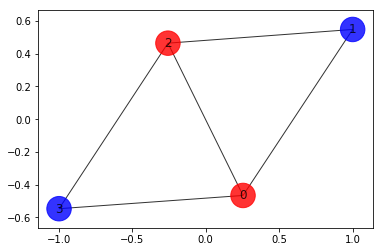

In [49]:
spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

# The logging is very verbose, but really helps.

You can turn it off with the following code for now to keep the notebook clean. I recommend always keeping it on.

In [62]:
# set_qiskit_aqua_logging(logging.WARNING)

Now, let's try a new optimizer. This is a big part of the power of Aqua. The Aqua team spends time making the components broadly compatable, so experimentation is cheap and easy.

energy: -1.4999999816380292
time: 27.44013285636902
max-cut objective: -3.9999999816380294
solution: [0. 1. 0. 1.]
solution objective: 4.0


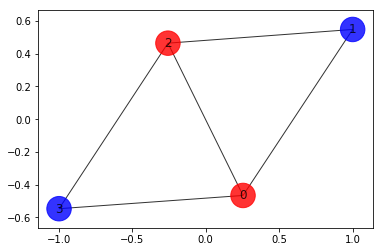

In [58]:
vqe = VQE(qubitOp, ry, SLSQP())
result = vqe.run(quantum_instance)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

Empirical notes on optimizers:
* COBYLA is a generally good global optimizer, especially in situations when you do not have a good starting point
* SLSQP is very good when you have a good starting point, and the error surface can be approximated in small cavities by quadratic functions
* SPSA is generally resilient to noise, so almost always the first choise for running on the hardware or noisy simulations

Know your optimizer! Understanding the high-level behavior goes a long way.

Now let's try a new variational form:

energy: -1.4999968807436779
time: 186.41802167892456
max-cut objective: -3.999996880743678
solution: [0. 1. 0. 1.]
solution objective: 4.0


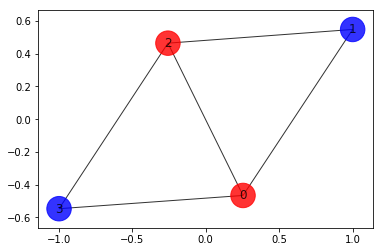

In [63]:
ryrz = RYRZ(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ryrz, SLSQP())
result = vqe.run(quantum_instance)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

That seemed to work worse. We can also increase variational form depth and change the connectivity:

energy: -1.4999994562397423
time: 110.27336883544922
max-cut objective: -3.9999994562397423
solution: [0. 1. 0. 1.]
solution objective: 4.0


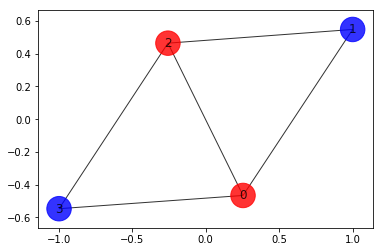

In [64]:
ry = RY(qubitOp.num_qubits, depth=8, entanglement='full')
vqe = VQE(qubitOp, ry, SLSQP())
result = vqe.run(quantum_instance)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In many cases we can even swap out the **algorithm**:

2019-10-25 05:13:34,488:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of QAOA.Variational ============================
Algorithm: QAOA.Variational
-- quantum_instance: None
-- var_form: <qiskit.aqua.algorithms.adaptive.qaoa.var_form.QAOAVarForm object at 0x119b01f28>
-- optimizer: <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x119b8fd68>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.qaoa.qaoa.QAOA object at 0x11bc578d0>>
-- initial_point: [0, 0, 0, 0, 0, 0, 0, 0]
-- callback: None
-- operator: Representation: paulis, qubits: 4, size: 5
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: QAOAVarForm
-- cost_operator: Representation: paulis, qubits: 4, size: 5
-- p: 4
-- initial_state: None
-- mixer_operator: Representation: paulis, qubits: 4, size: 4
Optimizer: COBYLA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'rhobeg

2019-10-25 05:13:40,668:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 54 returned -0.9840603971375299
2019-10-25 05:13:40,783:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 55 returned -0.9892310163898511
2019-10-25 05:13:40,899:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 56 returned -0.9937584682957503
2019-10-25 05:13:41,015:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 57 returned -0.9919804583701997
2019-10-25 05:13:41,136:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 58 returned -0.964517628116563
2019-10-25 05:13:41,251:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 59 returned -0.9937833050820558
2019-10-25 05:13:41,366:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 60 returned -0.9953528666102494
2019-10-25 05:13:41,479:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 61 returned -0.993272620358737
2019-10-25 05:13:41,603:qiskit.aqua.algori

2019-10-25 05:13:49,135:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 123 returned -1.374926461205041
2019-10-25 05:13:49,253:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 124 returned -1.3795231395096201
2019-10-25 05:13:49,372:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 125 returned -1.3743033539477079
2019-10-25 05:13:49,492:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 126 returned -1.3814323774706185
2019-10-25 05:13:49,613:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 127 returned -1.380386374322545
2019-10-25 05:13:49,730:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 128 returned -1.3816921699703812
2019-10-25 05:13:49,848:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 129 returned -1.3786092775846945
2019-10-25 05:13:49,970:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 130 returned -1.38174279371938
2019-10-25 05:13:50,098:qiskit.aqua.

2019-10-25 05:13:57,177:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 191 returned -1.4121475171750002
2019-10-25 05:13:57,284:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 192 returned -1.4115820837309248
2019-10-25 05:13:57,391:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 193 returned -1.4122763675966743
2019-10-25 05:13:57,498:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 194 returned -1.412688030014785
2019-10-25 05:13:57,608:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 195 returned -1.412907201404012
2019-10-25 05:13:57,726:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 196 returned -1.4133716250353492
2019-10-25 05:13:57,835:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 197 returned -1.4138037476994563
2019-10-25 05:13:57,947:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 198 returned -1.414128197224344
2019-10-25 05:13:58,068:qiskit.aqua

2019-10-25 05:14:05,632:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 259 returned -1.4287593191062695
2019-10-25 05:14:05,752:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 260 returned -1.4289454036518148
2019-10-25 05:14:05,874:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 261 returned -1.4292787482686506
2019-10-25 05:14:05,993:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 262 returned -1.4295281531113972
2019-10-25 05:14:06,111:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 263 returned -1.4296180213986671
2019-10-25 05:14:06,225:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 264 returned -1.4293983298043844
2019-10-25 05:14:06,334:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 265 returned -1.4301265750472647
2019-10-25 05:14:06,447:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 266 returned -1.430368886710706
2019-10-25 05:14:06,559:qiskit.aq

2019-10-25 05:14:13,766:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 327 returned -1.4492034360146973
2019-10-25 05:14:13,873:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 328 returned -1.4494304604243071
2019-10-25 05:14:13,984:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 329 returned -1.450090828937191
2019-10-25 05:14:14,092:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 330 returned -1.4505979287291875
2019-10-25 05:14:14,206:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 331 returned -1.4509814133642833
2019-10-25 05:14:14,334:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 332 returned -1.451520330997349
2019-10-25 05:14:14,444:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 333 returned -1.4511367937873132
2019-10-25 05:14:14,554:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 334 returned -1.4515823191036883
2019-10-25 05:14:14,661:qiskit.aqu

2019-10-25 05:14:22,058:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 395 returned -1.4777277913504279
2019-10-25 05:14:22,168:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 396 returned -1.478302492425568
2019-10-25 05:14:22,282:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 397 returned -1.4787736417585764
2019-10-25 05:14:22,393:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 398 returned -1.4792197526751851
2019-10-25 05:14:22,507:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 399 returned -1.479200761493612
2019-10-25 05:14:22,623:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 400 returned -1.4792256984860817
2019-10-25 05:14:22,741:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 401 returned -1.4796545154271814
2019-10-25 05:14:22,867:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 402 returned -1.4801458663209126
2019-10-25 05:14:22,979:qiskit.aqu

2019-10-25 05:14:30,323:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 463 returned -1.4912736471201935
2019-10-25 05:14:30,434:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 464 returned -1.4913146826004244
2019-10-25 05:14:30,544:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 465 returned -1.491321088772343
2019-10-25 05:14:30,657:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 466 returned -1.491408999727861
2019-10-25 05:14:30,778:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 467 returned -1.4913251372792784
2019-10-25 05:14:30,892:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 468 returned -1.4915024049093528
2019-10-25 05:14:31,000:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 469 returned -1.4915088687465303
2019-10-25 05:14:31,107:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 470 returned -1.4914681326934618
2019-10-25 05:14:31,218:qiskit.aqu

2019-10-25 05:14:38,796:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 531 returned -1.4938814750968068
2019-10-25 05:14:38,907:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 532 returned -1.4939259586012221
2019-10-25 05:14:39,023:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 533 returned -1.4939514422557205
2019-10-25 05:14:39,146:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 534 returned -1.4939608431385822
2019-10-25 05:14:39,258:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 535 returned -1.493956128563991
2019-10-25 05:14:39,368:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 536 returned -1.4939871368179531
2019-10-25 05:14:39,483:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 537 returned -1.4939962066655705
2019-10-25 05:14:39,601:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 538 returned -1.4940001334799757
2019-10-25 05:14:39,718:qiskit.aq

2019-10-25 05:14:46,852:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 599 returned -1.4947439001898415
2019-10-25 05:14:46,971:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 600 returned -1.4947488767162644
2019-10-25 05:14:47,089:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 601 returned -1.4947618170499286
2019-10-25 05:14:47,207:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 602 returned -1.4947643275009797
2019-10-25 05:14:47,319:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 603 returned -1.4947661455788146
2019-10-25 05:14:47,433:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 604 returned -1.4947692576496445
2019-10-25 05:14:47,550:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 605 returned -1.4947540201643532
2019-10-25 05:14:47,672:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 606 returned -1.4947667813427568
2019-10-25 05:14:47,786:qiskit.a

2019-10-25 05:14:55,159:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 667 returned -1.4949387214501997
2019-10-25 05:14:55,274:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 668 returned -1.494935836139824
2019-10-25 05:14:55,384:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 669 returned -1.4949401542437388
2019-10-25 05:14:55,492:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 670 returned -1.494937811027691
2019-10-25 05:14:55,605:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 671 returned -1.4949425587630794
2019-10-25 05:14:55,727:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 672 returned -1.4949464286796692
2019-10-25 05:14:55,850:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 673 returned -1.4949463268212777
2019-10-25 05:14:55,963:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 674 returned -1.4949461909674866
2019-10-25 05:14:56,074:qiskit.aqu

2019-10-25 05:15:03,225:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 735 returned -1.495009203657651
2019-10-25 05:15:03,346:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 736 returned -1.4950109485771592
2019-10-25 05:15:03,465:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 737 returned -1.4950126436764446
2019-10-25 05:15:03,581:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 738 returned -1.495013978420682
2019-10-25 05:15:03,688:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 739 returned -1.495014381440198
2019-10-25 05:15:03,801:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 740 returned -1.4950158530736744
2019-10-25 05:15:03,911:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 741 returned -1.4950152652300535
2019-10-25 05:15:04,019:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 742 returned -1.495016170873252
2019-10-25 05:15:04,131:qiskit.aqua.

2019-10-25 05:15:11,181:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 803 returned -1.49505719255031
2019-10-25 05:15:11,295:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 804 returned -1.4950589875424396
2019-10-25 05:15:11,403:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 805 returned -1.4950597393018281
2019-10-25 05:15:11,510:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 806 returned -1.4950594506115187
2019-10-25 05:15:11,623:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 807 returned -1.4950598600831513
2019-10-25 05:15:11,730:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 808 returned -1.495061315887675
2019-10-25 05:15:11,838:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 809 returned -1.4950626489165058
2019-10-25 05:15:11,947:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 810 returned -1.4950637062269418
2019-10-25 05:15:12,059:qiskit.aqua

2019-10-25 05:15:19,269:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 871 returned -1.4950954874231712
2019-10-25 05:15:19,376:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 872 returned -1.4950971428065438
2019-10-25 05:15:19,484:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 873 returned -1.4950974450760681
2019-10-25 05:15:19,596:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 874 returned -1.4950971798277553
2019-10-25 05:15:19,703:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 875 returned -1.4950989446117935
2019-10-25 05:15:19,809:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 876 returned -1.495099471068602
2019-10-25 05:15:19,916:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 877 returned -1.49509957325496
2019-10-25 05:15:20,028:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 878 returned -1.4950984021203564
2019-10-25 05:15:20,135:qiskit.aqua

2019-10-25 05:15:27,396:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 939 returned -1.4951289212197896
2019-10-25 05:15:27,507:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 940 returned -1.4951282997671047
2019-10-25 05:15:27,621:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 941 returned -1.4951296391546753
2019-10-25 05:15:27,735:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 942 returned -1.4951295130919218
2019-10-25 05:15:27,849:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 943 returned -1.4951313215338269
2019-10-25 05:15:27,965:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 944 returned -1.495132641402602
2019-10-25 05:15:28,081:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 945 returned -1.4951338203074922
2019-10-25 05:15:28,196:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 946 returned -1.495134737854973
2019-10-25 05:15:28,306:qiskit.aqu

energy: -1.4951825844295117
time: 120.12980508804321
max-cut objective: -3.9951825844295117
solution: [0. 1. 0. 1.]
solution objective: 4.0


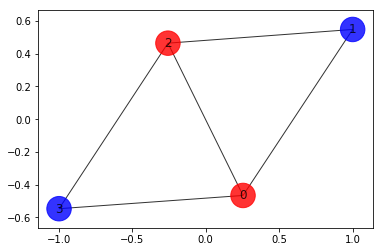

In [70]:
qaoa = QAOA(qubitOp, COBYLA(), p=4)
result = qaoa.run(quantum_instance)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

# Other Neat Stuff

Aqua has many core algorithms, including:
* VQE
* QAOA
* QPE/iterativeQPE
* Hamiltonian Evolution
* Quantum-Kernel SVM
* Variational SVM
* Grover’s

# Example: Quantum ML with Support Vector Machines

Q-Kernel SVM: We use a standard classical SVM with a “quantum kernel.” The kernel is an nxn matrix (n is the number of training samples), where matrix element m, p is generated by running short variational circuits of the form ⟨variational _form(m)|variational_form(p)⟩ for every point m, p in the training set. Note that a single point m is a list of features. This kernel extends the reach of the feature space beyond what we believe is possible classically.

Q-Variational SVM: To train, we input a sample as the initial state of a short variational circuit, with parameters, and read the result (mod 2) to find the circuit’s classification. We optimize the parameters of the variational circuit classically to improve the model’s classification accuracy.
Warning: the variational svm can be very slow to converge.

Task below: attempt to fit a very nonlinear function, f(x,y) = x*y


In [78]:
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
import time
from sklearn import svm

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

Let's start by creating and visalizing our sample data.

In [76]:
train_size = 50
test_size = 20

x_trn = (np.random.random(train_size)*2)-1
y_trn = (np.random.random(train_size)*2)-1
greater = [[x,y] for x,y in zip(x_trn,y_trn) if x*y >=0]
less = [[x,y] for x,y in zip(x_trn,y_trn) if x*y < 0]
training_data = {"greater": greater, "less":less}
print(training_data)

x_tst = (np.random.random(test_size)*2)-1
y_tst = (np.random.random(test_size)*2)-1
greater = [[x,y] for x,y in zip(x_tst,y_tst) if x*y >=0]
less = [[x,y] for x,y in zip(x_tst,y_tst) if x*y < 0]
test_data = {"greater": greater, "less":less}
print(test_data)

{'greater': [[0.6207632944768593, 0.48025899511576786], [0.992482171707675, 0.0402329334117828], [0.03250554882845935, 0.12920082421807533], [-0.9931382105652415, -0.5853082458160479], [-0.7376173228742011, -0.8582142796043388], [-0.07196649417798939, -0.6850042312837521], [-0.8020637814261868, -0.563988112037642], [-0.43311746789099836, -0.722039243425967], [-0.5423049336480694, -0.5510084058043556], [-0.6963575659903531, -0.6531667132865038], [-0.20300395593001563, -0.7600903078362906], [0.6989771203173036, 0.10872773726340945], [-0.10473768228405556, -0.8029266223830094], [0.3654353911265593, 0.052442991902163616], [0.8894845641841898, 0.7911683182595919], [0.8555118042267236, 0.7149307259432236], [0.2848566194584188, 0.2275486899296737], [-0.3192135996421239, -0.20163640954443762], [-0.3652450181077216, -0.1102427163938915], [-0.9495774356041689, -0.5221056436995304], [0.5789678782971515, 0.1732300671700746], [0.97824641024125, 0.001616668412687039], [-0.5493635950505471, -0.831848

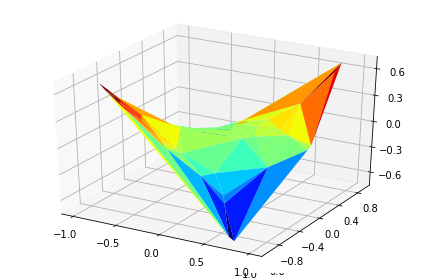

In [77]:
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x_trn, y_trn, x_trn*y_trn, cmap=cm.jet, linewidth=0) #Jet4Ever
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show()

Let's define a function to fit the data with the quantum kernel svm, and test it. This will take a while, maybe 20-30 minutes. It scales with O(n^2).

In [86]:
feature_map = SecondOrderExpansion(feature_dimension=2, depth=2, entanglement='linear')
qsvm = QSVM(feature_map, training_data, test_data)
result = qsvm.run(quantum_instance)
print("test accuracy: {}%".format(result['testing_accuracy']*100))

2019-10-25 05:26:26,764:qiskit.aqua.components.feature_maps.pauli_expansion:INFO: Pauli terms include: ['IZ', 'ZI', 'ZZ']


test accuracy: 70.0%


# We get a bunch of other great stuff back in the result object:

In [84]:
result

{'kernel_matrix_training': array([[1.        , 0.37322235, 0.46318156, ..., 0.04001994, 0.37439791,
         0.22603333],
        [0.37322235, 1.        , 0.25715282, ..., 0.01477777, 0.49915587,
         0.16123368],
        [0.46318156, 0.25715282, 1.        , ..., 0.45535174, 0.13577369,
         0.71527164],
        ...,
        [0.04001994, 0.01477777, 0.45535174, ..., 1.        , 0.26193717,
         0.87278351],
        [0.37439791, 0.49915587, 0.13577369, ..., 0.26193717, 1.        ,
         0.11850011],
        [0.22603333, 0.16123368, 0.71527164, ..., 0.87278351, 0.11850011,
         1.        ]]),
 'svm': {'alphas': array([122.00753155, 772.82481574,  93.48277401, 478.47113017,
          77.79485906, 404.01623188,  24.54002572, 366.01413679,
         464.26528796, 106.37025148, 298.52175349, 312.56528485,
          45.5193674 , 114.33522141, 265.54607811]),
  'bias': array([0.76828346]),
  'support_vectors': array([[ 0.99248217,  0.04023293],
         [ 0.03250555,  0.12920

Now let's try swapping it out for the Variational SVM. This will probably take closer to 10 minutes.

In [96]:
vqc = VQC(optimizer=COBYLA(), 
          feature_map=feature_map,
          var_form=RY(2, depth=3),
          training_dataset=training_data, 
          test_dataset=test_data,
          max_evals_grouped=100
         )
result = vqc.run(quantum_instance)
print("test accuracy: {}%".format(result['testing_accuracy']*100))

2019-10-25 05:31:22,359:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-1.58510546  0.80789829 -0.00773955  0.32623268 -0.61057368  2.2107385
  0.31549583 -1.0674794 ]
2019-10-25 05:38:46,336:qiskit.aqua.algorithms.adaptive.vqc.vqc:INFO: Optimization complete in 443.97705125808716 seconds.
Found opt_params [-1.63800166  1.10237984 -0.20020115  1.58692384 -1.56104876  2.47435979
  1.62424457 -0.03293275] in 159 evals
2019-10-25 05:38:47,369:qiskit.aqua.algorithms.adaptive.vqc.vqc:INFO: Accuracy is 80.00%


test accuracy: 80.0%


And for good measure, let's score these against a popular set of classical SVM kernels:

In [97]:
def classical_svm_score(samples_tr, labels_tr, samples_te, labels_te, kernel='linear'):
    model = svm.SVC(kernel=kernel, gamma='auto')
    model.fit(samples_tr, labels_tr)
    return model.score(samples_te, labels_te)

In [98]:
samples_train = list(zip(x_trn, y_trn))
samples_test = list(zip(x_tst, y_tst))
labels_train = [x*y>=0 for [x,y] in samples_train]
labels_test = [x*y>0 for [x,y] in samples_test]

perf = {'rbf':[], 'linear':[], 'poly':[], 'sigmoid':[]}
for key in perf:
    perf[key] = classical_svm_score(samples_train, 
                                        labels_train, 
                                        samples_test, 
                                        labels_test, 
                                        kernel=key)
print(perf)

{'rbf': 0.65, 'linear': 0.45, 'poly': 0.35, 'sigmoid': 0.55}


# Part IV: Qiskit Chemistry

# Qiskit Chemistry is a Convenient Wrapper Around Aqua and Popular Chemistry Drivers

* Qiskit Chemistry is an even more practitioner-centric tool, specifically for Chemists
* It includes two other component buckets that are not in Aqua: Chemistry drivers, and mappings (Jordan-Wigner, Bravyi-Kitaev, parity, etc.)
* The interfaces look very similar to Aqua - instantiation with a dictionary, or a standalone UI, etc.
* The core service of Qiskit Chemistry is to prepare all of the required calculations for the hamiltonian and other important observables before attempting to do Chemistry simulation or eigendecomposition in Aqua


This tutorial is based on [this notebook](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aqua/chemistry/programmatic_approach.ipynb) by Richard Chen, Antonio Mezzacapo, Marco Pistoia, and Stephen Wood.

In [ ]:
#!pip install qiskit
#!pip install pyscf

In [100]:
import numpy as np
import pylab

# import common packages
import numpy as np

from qiskit import Aer

# lib from Qiskit Aqua
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.components.optimizers import COBYLA

# lib from Qiskit Aqua Chemistry
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.aqua_extensions.components.variational_forms import UCCSD
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock

# Most Important Thing to Grasp - the Execution Flow:

* Qiskit Chemistry discovers components and reads config dictionaries
* Most fancy Chemistry package features are allowed, like orbital removal, qubit tapering, core freezing, etc.
* Calls Chemistry Drivers to calculate single and double excitation integrals
* Uses mapping to create a hamiltonian circuit out of operators for each excitation
* Calls VQE in Aqua to find eigenstates of the hamiltonian (e.g. ground state energy)
  * Also passes aux_ops (auxiliary operators) for Aqua to calculate at the end: spin, particle number, dipole moment, etc.
* Aqua creates an “evaluate_energy” function which: 
  * Takes in a scalar parameter list, creates a variational form (UCCSD, RyRz, Swap-Rz, your own, etc.) parameterized by the list
  * Executes the variational circuit + the hamiltonian circuit (or does math in the background to simulate the result quickly without sending the full circuit to the simulator)
  * Returns the resulting energy of the system
* Aqua instantiates an optimizer, and passes the energy function as the cost function to minimize
  * Use COBYLA if running on statevector simulator, SPSA if running on shot-based (qasm) because it performs well in the presence of noise
* The optimizer minimizes the energy, and returns the optimal parameters when complete
* Aqua re-creates the ground state with the optimal params, and calculates and returns the ground state energy and auxiliary operators

# Let's start with a simple example, NaH:

First, we call a classical quantum chemistry driver to get the one and two body excitation integrals.

In [103]:
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 1.1', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

System: uname_result(system='Darwin', node='Donnys-MacBook-Pro.local', release='18.7.0', version='Darwin Kernel Version 18.7.0: Thu Jun 20 18:42:21 PDT 2019; root:xnu-4903.270.47~4/RELEASE_X86_64', machine='x86_64', processor='i386')  Threads 1
Python 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.15.4  scipy 1.1.0
Date: Fri Oct 25 06:20:09 2019
PySCF version 1.5.4
PySCF path  /Users/donny.greenberg@ibm.com/code/Education/lib/python3.6/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 4
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = Angstrom
[INPUT]  1 Li     0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 H      0.000000000000   0.000000000000   1.100000000000 AA    0.000000000000   0.000000000000   2.078

# Next, we construct the electronic structure Hamiltonian using the integrals

We have to specify a qubit mapping to encode our electronic structure in our binary variables. Here we're using the "parity" mapping.

In [109]:
# If we like, we can specify orbitals to freeze or remove here.
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order
map_type = 'parity'

h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -9.251953751729783
# of electrons: 4
# of spin orbitals: 12


In [110]:
# prepare full idx of freeze_list and remove_list
# convert all negative idx to positive
remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
# update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]

# prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
# and if PARITY mapping is selected, reduction qubits
energy_shift = 0.0
qubit_reduction = True if map_type == 'parity' else False

ferOp = FermionicOperator(h1=h1, h2=h2)
if len(freeze_list) > 0:
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
if len(remove_list) > 0:
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)

qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
qubitOp.chop(10**-10)

print(qubitOp.print_details())
print(qubitOp)

|██████████████████████████████████████████████████| 18/18 [00:00:00:00]
|██████████████████████████████████████████████████| 324/324 [00:00:00:00]


IIII	(-0.21737866310949602+0j)
IIIZ	(-0.08439854126694982+0j)
IIZX	(-0.0009404146897616082+0j)
IIIX	(0.0009404146897616082+0j)
IIXX	(0.002141686287666407+0j)
IIYY	(-0.002141686287666407+0j)
IIZZ	(-0.20530828544545388+0j)
IIXZ	(0.021107333603250275+0j)
IIXI	(0.021107333603250275+0j)
IIZI	(0.3951922323383774+0j)
IZII	(0.08439854126694976+0j)
ZXII	(0.0009404146897616108+0j)
IXII	(0.0009404146897616108+0j)
XXII	(0.0021416862876664105+0j)
YYII	(-0.0021416862876664105+0j)
ZZII	(-0.20530828544545376+0j)
XZII	(-0.02110733360325028+0j)
XIII	(0.02110733360325028+0j)
ZIII	(-0.3951922323383774+0j)
IZIZ	(-0.13014781508798345+0j)
IZZX	(0.010175022571734523+0j)
IZIX	(-0.010175022571734523+0j)
IZXX	(0.03899949866977677+0j)
IZYY	(-0.03899949866977677+0j)
IXIZ	(0.010175022571734523+0j)
ZXIZ	(0.010175022571734523+0j)
IXZX	(-0.002442323717283872+0j)
ZXZX	(-0.002442323717283872+0j)
IXIX	(0.002442323717283872+0j)
ZXIX	(0.002442323717283872+0j)
IXXX	(-0.007488359225976959+0j)
ZXXX	(-0.007488359225976959+0j)


# Let's Try Exactly Diagonalizing the Hamiltonian to See the Correct GSE

Note that we add back the other energy components (Nuclear, frozen) to the energy found in the Hamiltonian.

In [111]:
# Using exact eigensolver to get the smallest eigenvalue
exact_eigensolver = ExactEigensolver(qubitOp, k=1)
ret = exact_eigensolver.run()
print('The computed energy is: {:.12f}'.format(ret['eigvals'][0].real))
print('The total ground state energy is: {:.12f}'.format(ret['eigvals'][0].real + energy_shift + nuclear_repulsion_energy))

The computed energy is: -1.167749698480
The total ground state energy is: -7.823599276363


# Finally, we can use a Quantum algorithm to find the Ground State Wavefunction Circuit

* We'll use the UCCSD variational form, originally proposed in the VQE paper. 
* We'll also use the Hartree Fock state as the initial state of our calculation. 
    * This is done by appending a rotating circuit to the beginning of the ansatz, rather than manipulating the ansatz parameters directly.

In [115]:
# setup HartreeFock state
HF_state = HartreeFock(qubitOp.num_qubits, 
                       num_spin_orbitals, 
                       num_particles, 
                       map_type, 
                       qubit_reduction)

# setup UCCSD variational form
var_form = UCCSD(qubitOp.num_qubits, 
                 depth=1, 
                 num_orbitals=num_spin_orbitals, 
                 num_particles=num_particles, 
                 active_occupied=[0], active_unoccupied=[0, 1],
                 initial_state=HF_state, qubit_mapping=map_type, 
                 two_qubit_reduction=qubit_reduction, num_time_slices=1)

# setup VQE
vqe = VQE(qubitOp, var_form, COBYLA(maxiter=200))

|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
|██████████████████████████████████████████████████| 2/2 [00:00:00:00]
2019-10-25 06:33:37,235:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.chemistry.aqua_extensions.components.variational_forms.uccsd.UCCSD object at 0x111c298d0>
-- optimizer: <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x111c29898>
-- cost_fn: <bound method VQE._energy_evaluation of <qiski

In [116]:
results = vqe.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results['eigvals'][0]))
print('The total ground state energy is: {:.12f}'.format(results['eigvals'][0] + energy_shift + nuclear_repulsion_energy))
print("Parameters: {}".format(results['opt_params']))

2019-10-25 06:34:05,686:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: When running with non-Aer statevector simulator, represent operator as a matrix could achieve the better performance. We convert the operator to matrix.
2019-10-25 06:34:05,720:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[0. 0. 0. 0. 0. 0. 0. 0.]
|██████████████████████████████████████████████████| 8/8 [00:00:00:00]
2019-10-25 06:34:06,125:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 1 returned -1.1528935986101854
2019-10-25 06:34:06,494:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 2 returned -1.03784611076061

2019-10-25 06:34:37,324:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 64 returned -1.1677230347041572
2019-10-25 06:34:37,818:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 65 returned -1.1677175456307878
2019-10-25 06:34:38,287:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 66 returned -1.1677281306540748
2019-10-25 06:34:38,973:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 67 returned -1.1677279447067124
2019-10-25 06:34:39,464:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 68 returned -1.1677333457152566
2019-10-25 06:34:39,945:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 69 returned -1.1677111248110934
2019-10-25 06:34:40,415:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 70 returned -1.1677307152976053
2019-10-25 06:34:40,893:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 71 returned -1.167737685085648
2019-10-25 06:34:41,535:qiskit.aqua.algor

2019-10-25 06:35:11,782:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 133 returned -1.1677496605830229
2019-10-25 06:35:12,390:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 134 returned -1.1677496686166666
2019-10-25 06:35:12,820:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 135 returned -1.1677496503826879
2019-10-25 06:35:13,264:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 136 returned -1.1677496659748592
2019-10-25 06:35:13,721:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 137 returned -1.1677496695193539
2019-10-25 06:35:14,173:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 138 returned -1.1677496634593987
2019-10-25 06:35:14,785:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 139 returned -1.1677496793773046
2019-10-25 06:35:15,231:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 140 returned -1.1677496807117287
2019-10-25 06:35:15,662:qiskit.a

The computed ground state energy is: -1.167749683387
The total ground state energy is: -7.823599261271
Parameters: [ 0.02434977  0.0021029   0.0246514   0.0020708  -0.02662184  0.04482796
  0.04486171 -0.09713722]


The error relative to exact diagonalization is:

In [118]:
ret['eigvals'][0].real - results['eigvals'][0]

-1.5092234573188534e-08

Chemical accuracy is $10^{-3}$!

Other stuff we get with the results:

In [117]:
results

{'num_optimizer_evals': 144,
 'min_val': -1.1677496833873442,
 'opt_params': array([ 0.02434977,  0.0021029 ,  0.0246514 ,  0.0020708 , -0.02662184,
         0.04482796,  0.04486171, -0.09713722]),
 'eval_time': 71.41569876670837,
 'eval_count': 144,
 'energy': -1.1677496833873442,
 'eigvals': array([-1.16774968]),
 'min_vector': array([ 4.59929699e-06-0.00210163j,  0.00000000e+00+0.j        ,
         5.32664059e-05-0.02433986j,  2.17168597e-03-0.99234278j,
         9.80661863e-05-0.04481093j,  0.00000000e+00+0.j        ,
        -5.69052542e-05+0.02600262j,  5.39264907e-05-0.02464148j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        -2.11607977e-04+0.09669338j,  0.00000000e+00+0.j        ,
         9.80881080e-05-0.04482095j,  4.52907482e-06-0.00206954j]),
 'eigvecs': array([[ 4.59929699e-06-0.00210163j,  0.00000000e+00+0.j        ,
          5.32664059e-05-0.02433986j,  2.17168597e-03-0.99234

# Let's take a Look at Our Optimal Circuit

In [127]:
var_form.construct_circuit(results['opt_params']).draw(fold=4000)

## Yikes! We'll need something NISQ-y.

# UCCSD is Not NISQ-Practical. How will a Hardware-efficient Ansatz do?

In [128]:
help(RY)

Help on class RY in module qiskit.aqua.components.variational_forms.ry:

class RY(qiskit.aqua.components.variational_forms.variational_form.VariationalForm)
 |  Layers of Y rotations followed by entangling gates.
 |  
 |  Method resolution order:
 |      RY
 |      qiskit.aqua.components.variational_forms.variational_form.VariationalForm
 |      qiskit.aqua.pluggable.Pluggable
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_qubits, depth=3, entangler_map=None, entanglement='full', initial_state=None, entanglement_gate='cz', skip_unentangled_qubits=False, skip_final_ry=False)
 |      Constructor.
 |      
 |      Args:
 |          num_qubits (int) : number of qubits
 |          depth (int) : number of rotation layers
 |          entangler_map (list[list]): describe the connectivity of qubits, each list describes
 |                                      [source, target], or None for full entanglement.
 |                                   

In [138]:
ry_hf = RY(qubitOp.num_qubits, 
              depth=3,
              entanglement='full',
              initial_state=HF_state)

# setup VQE
vqe_ry = VQE(qubitOp, ry_hf, COBYLA(maxiter=200))

2019-10-25 06:54:13,715:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x11ce109b0>
-- optimizer: <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x11ce10748>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x11cc89320>>
-- initial_point: Random seed
-- callback: None
-- operator: Representation: paulis, qubits: 4, size: 100
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: RY
-- num_parameters: 16
-- num_qubits: 4
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

In [139]:
results_ry = vqe_ry.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results_ry['eigvals'][0]))
print('The total ground state energy is: {:.12f}'.format(results_ry['eigvals'][0] + energy_shift + nuclear_repulsion_energy))
print("Parameters: {}".format(results_ry['opt_params']))
print("Error relative to exact diagonalization: {}".format(ret['eigvals'][0].real - results_ry['eigvals'][0]))

2019-10-25 06:54:15,597:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: When running with non-Aer statevector simulator, represent operator as a matrix could achieve the better performance. We convert the operator to matrix.
2019-10-25 06:54:15,636:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.

2019-10-25 06:54:20,412:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 60 returned -0.9867882016124818
2019-10-25 06:54:20,486:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 61 returned -0.9853440306024345
2019-10-25 06:54:20,559:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 62 returned -0.9871622942147694
2019-10-25 06:54:20,634:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 63 returned -0.9888099871606346
2019-10-25 06:54:20,709:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 64 returned -0.9843290971542656
2019-10-25 06:54:20,786:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 65 returned -1.0004600523919989
2019-10-25 06:54:21,070:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 66 returned -1.0085686059969101
2019-10-25 06:54:21,148:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 67 returned -0.9939942715208294
2019-10-25 06:54:21,221:qiskit.aqua.algo

2019-10-25 06:54:26,030:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 129 returned -1.1263393913993345
2019-10-25 06:54:26,102:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 130 returned -1.1286755583181793
2019-10-25 06:54:26,174:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 131 returned -1.1267181273702898
2019-10-25 06:54:26,250:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 132 returned -1.1304137161537466
2019-10-25 06:54:26,326:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 133 returned -1.126626221225643
2019-10-25 06:54:26,400:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 134 returned -1.1263923890612035
2019-10-25 06:54:26,478:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 135 returned -1.1302273676149626
2019-10-25 06:54:26,556:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 136 returned -1.1308553957668617
2019-10-25 06:54:26,629:qiskit.aq

2019-10-25 06:54:31,515:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 197 returned -1.1586659192307747
2019-10-25 06:54:31,595:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 198 returned -1.1573805554824734
2019-10-25 06:54:31,669:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 199 returned -1.158404208050733
2019-10-25 06:54:31,743:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 200 returned -1.158399477088476
2019-10-25 06:54:31,744:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Optimization complete in 16.108237981796265 seconds.
Found opt_params [ 1.56843139  4.66392181  4.54600301 -1.76716171  2.4786288  -2.16850585
  0.56066875  1.16733325  1.69510203  1.61499414 -0.67862931  1.70550905
 -3.24709303  0.09989184 -2.03364328 -0.12876066] in 200 evals


The computed ground state energy is: -1.159284608104
The total ground state energy is: -7.815134185987
Parameters: [ 1.56843139  4.66392181  4.54600301 -1.76716171  2.4786288  -2.16850585
  0.56066875  1.16733325  1.69510203  1.61499414 -0.67862931  1.70550905
 -3.24709303  0.09989184 -2.03364328 -0.12876066]
Error relative to exact diagonalization: -0.008465090375538997


Worse, but not too bad! We can improve this with hyperparameter (ansatz, initial_point, etc.) tuning. And the circuit is more reasonable:

In [140]:
ry_hf.construct_circuit(results_ry['opt_params']).draw(fold=4000)

# Plotting a Full Dissociation Curve

I recommend trying to plot the full dissociation profile for LiH (this will take a while - maybe over 20 minutes) based on [this notebook](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aqua/chemistry/dissociation_profile_of_molecule.ipynb) 📒 by Mezzacapo et al. Notice, the reuse of the optimal parameters from a given point as the initial parameters for the following point. This gives us adiabatic-ish effects without having to run at extremely small distance steps.

# Tips!

* The examples above are somewhat naive, there are techniques to improve them by several orders of magnitude
* $|\text{Spin orbitals}| \approx |\text{qubits}|$ - if you increase the size of the molecule or basis, your classical execution time increases exponentially
* You don’t need to use VQE to find eigenstates! You can use QPE, QAOA, or whatever else
* Your initial point matters a lot. The way you move along a dissociation curve can dictate the fate of your resutlts.
* UCCSD is nice but it will not be runnable on Quantum hardware for a long time.
* Optimization over non-convex high-dimensional error surfaces is hard. I am sorry about that.